In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
def gkern1d(l=5, sig=1.):
    """\
    creates 1d gaussian kernel with length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    kernel = np.exp(-0.5 * np.square(ax) / np.square(sig))
    return kernel / np.sum(kernel)

In [3]:
def rvec(Nx,Ne,s):
    """\
    creates Ne 1d random noise vectors with length `Nx` and smoothed with Gaussian kernal std `s`
    """
    kernel = gkern1d(Nx,s)
    
    f = np.nan*np.zeros([Nx,Ne])
    
    for ii in np.arange(Ne):
        f[:,ii] = scipy.signal.convolve(np.random.randn(Nx),kernel,'same')

    return f

In [4]:
def rvecF(Nx,Ne,ss):
    """\
    creates Ne 1d random noise vectors with length `Nx` and smoothed with Gaussian kernal std `s`
    """
    # attempt to pin the ends out of vanity
    kernel = gkern1d(Nx,ss)
    
    f = np.nan*np.zeros([Nx,Ne])
    
    # Strategy: Make a longer smoothed time series than I need, then take the middle
    for ii in np.arange(Ne):        
        long = scipy.signal.convolve(np.random.randn(int(Nx-6*ss)),kernel,'full')
        start = int(len(long)/2-(Nx/2))
        f[:,ii] = long[start:(start+Nx)]

    return f

In [84]:
# Define some dimensions

# Number of sensitivities
Ns = 10

# Size of state
Nx = 500

# Number of ensemble members
Ne = 10000

# Spatial smoothing length scale
ss = Nx/10.
#s = .0001

# How many to plot up below
Nplot = 1

In [143]:
# Generate some spiky sensitivities in a region of the domain

# Noise amplitude desired in addition to spikes
eta_s = 0.0

#L = np.zeros([Nx,Ns])
S = np.random.randn(Nx,Ns)*eta_s

for ii in np.arange(Ns):
    S[np.random.randint(0,np.round(Nx/3)),ii] = np.random.rand()
    #S[np.random.randint(0,np.round(Nx/2)),ii] = 1.
    #L[np.random.randint(0,np.round(Nx/2)),ii] = 1. if np.random.random() < 0.5 else -1.

    #ri = np.random.randint(0,np.round(Nx/1))
    #L[ri,ii] = (100.-ri)/10
    

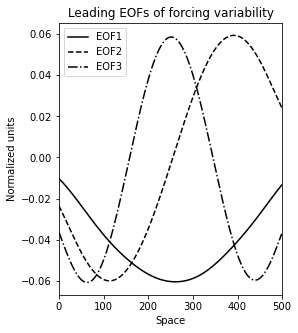

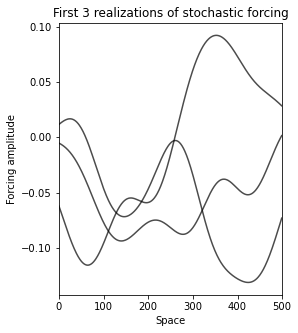

In [235]:
# Generate a data matrix

Xu = rvec(Nx,Ne,ss)
X = Xu-np.mean(Xu,1,keepdims=True)
C = (1/(Ne-1))*X.dot(X.T)

[U,Sig,Vt] = np.linalg.svd(np.sqrt(1/(Ne-1))*X,full_matrices=False)

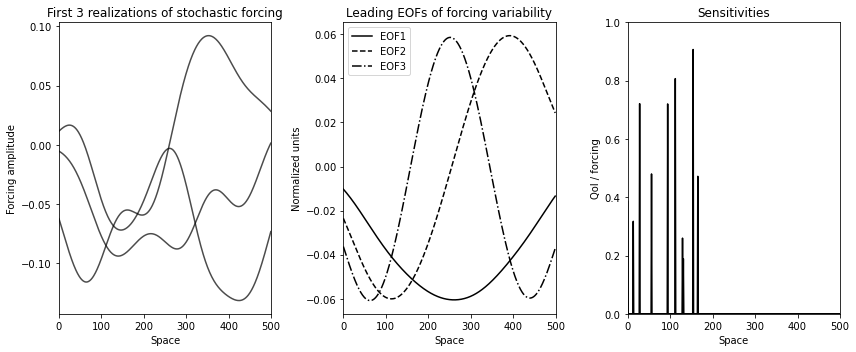

In [247]:
f, (a0,a1,a2) = plt.subplots(1, 3, figsize=(12,5))

a0.plot(X[:,:3],'k',alpha=0.7)
a0.set_title('First 3 realizations of stochastic forcing')
a0.set_ylabel('Forcing amplitude')
a0.set_xlabel('Space')
a0.set_xlim([0,500])

a1.plot(U[:,0],'-k')
a1.plot(U[:,1],'--k')
a1.plot(U[:,2],'-.k')
a1.set_title('Leading EOFs of forcing variability')
a1.set_ylabel('Normalized units')
a1.set_xlabel('Space')
a1.legend(['EOF1','EOF2','EOF3'])
a1.set_xlim([0,500])

a2.plot(S,'k');
a2.set_title('Sensitivities')
a2.set_ylabel('QoI / forcing')
a2.set_xlabel('Space')
a2.set_xlim([0,500])
a2.set_ylim([0,1])

f.tight_layout()

plt.savefig('Figs/setup.png', dpi=300)

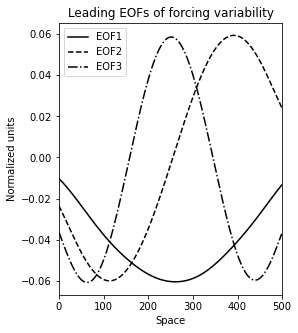

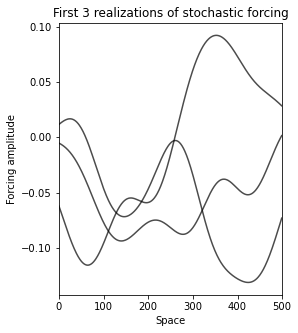

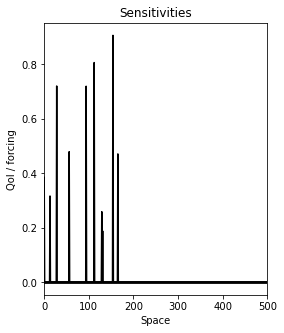

In [241]:
plt.figure(figsize=(4,5))
plt.plot(X[:,:3],'k',alpha=0.7)
plt.title('First 3 realizations of stochastic forcing')
plt.ylabel('Forcing amplitude')
plt.xlabel('Space')
plt.xlim([0,500])
plt.savefig('Figs/reals.png', dpi=300)

#plt.plot(U[:,:3])
plt.figure(figsize=(4,5))
plt.plot(U[:,0],'-k')
plt.plot(U[:,1],'--k')
plt.plot(U[:,2],'-.k')
plt.title('Leading EOFs of forcing variability')
plt.ylabel('Normalized units')
plt.xlabel('Space')
plt.legend(['EOF1','EOF2','EOF3'])
plt.xlim([0,500])
plt.savefig('Figs/eofs.png', dpi=300)
plt.show()

plt.figure(figsize=(4,5))
plt.plot(S,'k');
plt.title('Sensitivities')
plt.ylabel('QoI / forcing')
plt.xlabel('Space')
plt.xlim([0,500])
plt.savefig('Figs/sens.png', dpi=300)

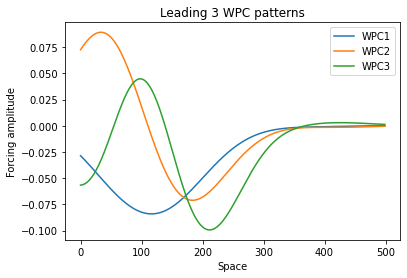

In [230]:
# Time series - based approach
[L,G,Tt] = np.linalg.svd(np.sqrt(1/(Ne-1))*S.T.dot(X),full_matrices=False)

P = np.sqrt(1/(Ne-1))*X.dot(Tt.T)#.dot(np.diag(1/S))
plt.plot((P/np.linalg.norm(P,axis=0))[:,:3])
plt.title('Leading 3 WPC patterns')
plt.ylabel('Forcing amplitude')
plt.xlabel('Space')
plt.legend(['WPC1','WPC2','WPC3'])
plt.savefig('Figs/wpcs.png', dpi=300)


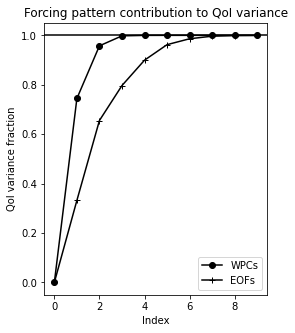

In [231]:
f, (a0,a1) = plt.subplots(1, 2, figsize=(8,5))

sigma_tot = np.trace(S.dot(S.T).dot(C))

eof_sigs = np.empty(len(G))
for ii in np.arange(len(G)):
    eof_sigs[ii] = np.trace(S.dot(S.T).dot(np.outer(U[:,ii],(U[:,ii].T))*Sig[ii]**2))

S0 = np.insert(G,0,0)
eof_sigs0 = np.insert(eof_sigs,0,0)

plt.figure(figsize=(4,5))

#plt.axhline(np.sum(S0**2),color='k',label='_nolegend_')
plt.axhline(1,color='k',label='_nolegend_')
plt.plot(np.cumsum(S0**2)[:10]/np.sum(S0**2),'ko-')    
plt.plot(np.cumsum(eof_sigs0[:10])/np.sum(S0**2),'k+-')

plt.legend(['WPCs','EOFs'])
plt.title('Forcing pattern contribution to QoI variance')
plt.ylabel('QoI variance fraction')
plt.xlabel('Index')
plt.savefig('Figs/contribs.png', dpi=300)

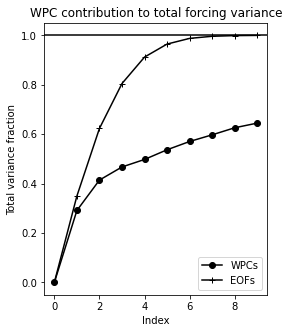

In [232]:
C_totvar = np.sum(Sig**2)

wpc_sigs = np.empty(len(G))
for ii in np.arange(len(G)):
    #Pn = P[:,ii]/np.linalg.norm(P[:,ii])
    wpc_sigs[ii] = np.linalg.norm(X.dot(Tt[ii,:])/np.sqrt(Ne-1))
    #wpc_sigs[ii] = np.trace(C.dot(np.outer(P[:,ii],(P[:,ii].T))/np.linalg.norm(P[:,ii]**2)))
    #wpc_sigs[ii] = (np.linalg.norm(P[:,ii])*np.linalg.norm(Tt[ii,:]))**2
    
Sig0 = np.insert(Sig,0,0)
wpc_sigs0 = np.insert(wpc_sigs,0,0)

plt.figure(figsize=(4,5))

#plt.axhline(np.sum(S0**2),color='k',label='_nolegend_')
plt.axhline(1,color='k',label='_nolegend_')
plt.plot(np.cumsum(wpc_sigs0[:10]**2)/np.sum(Sig0**2),'ko-')
plt.plot(np.cumsum(Sig0**2)[:10]/np.sum(Sig0**2),'k+-')    

plt.legend(['WPCs','EOFs'])
plt.title('WPC contribution to total forcing variance')
plt.ylabel('Total variance fraction')
plt.xlabel('Index')
plt.savefig('Figs/contribsC.png', dpi=300)

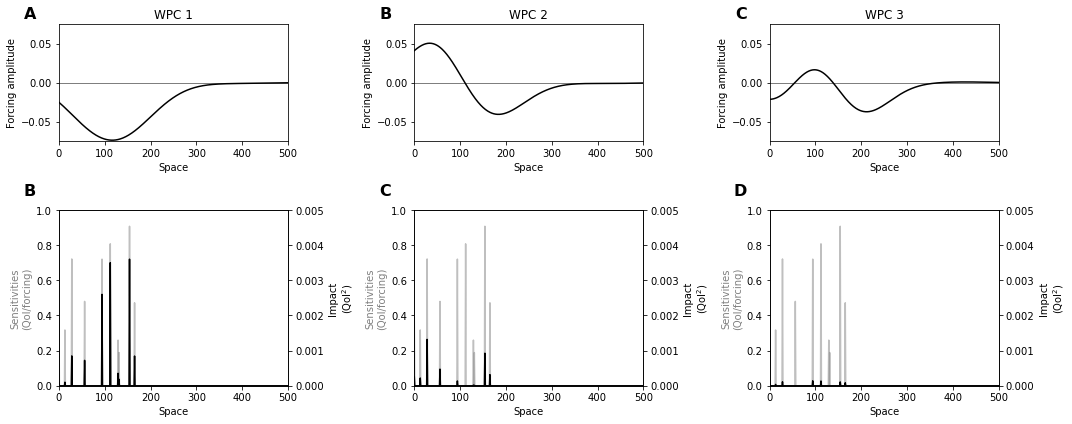

In [240]:
# Left SV expts
# These sum to total QoI var

# Is this any different than a naive projection onto S?

R = S.dot(L)


f, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [2, 3]},figsize=(15,6))

labels = ('A','B','C','D','E','F')

for ii in np.arange(3):
    
    a0 = ax[0,ii]
    a1 = ax[1,ii]
    
    l1=a0.axhline(0.0,color='black',ls='-',lw=.5)
    #a0.axhline(1,color='k',label='_nolegend_')
    a0.plot(P[:,ii]/np.linalg.norm(P[:,ii])*wpc_sigs[ii],'k')
    a0.set_ylim([-0.075,0.075])
    a0.set_xlim([0,500])
    a0.set_xlabel('Space')
    a0.set_ylabel('Forcing amplitude')
    a0.set_title('WPC '+str(ii+1))
    label = labels[ii]
    a0.text(-0.1, 1.15, label, transform=a0.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
    
#    a1.plot(R[:,ii]*P[:,ii]*G[ii],'k')
    a1.plot(S,'grey',alpha = 0.5)
    a1.set_ylim([0.0,1.0])
    a1.set_xlabel('Space')
    a1.set_ylabel('Sensitivities\n(QoI/forcing)',color='grey')

    a2 = a1.twinx()
    a2.plot(R[:,ii]*P[:,ii]*G[ii],'k')
    a2.set_ylim([0.0,0.005])
    a2.set_xlim([0,500])
    a2.set_ylabel('Impact\n(QoI$^2$)',color='k')
    label = labels[ii+1]
    a2.text(-0.1, 1.15, label, transform=a1.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    

f.tight_layout()

plt.show()
    